In [4]:
import math
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.datasets import imdb
from keras.utils import pad_sequences 
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import pipeline

In [5]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

 # Завдання

В якості домашнього завдання вам пропонується створити рекурентну нейронну мережу за допомогою механізмів Keras, яка буде класифікувати рецензії із датасету imdb.

На відміну від прикладу в модулі 9 ми використаємо рекурентну нейронну мережу. Поекспериментуйте з будовою мережі - RNN, LSTM, двостороння та глибока.

Порівняйте результати та зробіть висновки.

In [5]:
max_features = 10000
max_len = 500
n_epochs = 10
batch_size = 128
num_classes = 1
label_dict = {1:"Possitive", 0: "Negative"}

In [9]:
data_set_imdb = imdb.load_data(num_words=max_features)

In [7]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 26s 16us/step
? begins better than it ends funny that the russian submarine crew ? all other actors it's like those scenes where documentary shots br br spoiler part the message ? was contrary to the whole story it just does not ? br br


In [10]:
joblib.dump(data_set_imdb, "data_set_imdb")
joblib.dump(word_index, "word_index_imdb")

['word_index_imdb']

In [6]:
data_set_imdb = joblib.load( "data_set_imdb")
word_index = joblib.load( "word_index_imdb")

In [7]:
(train_data, train_labels), (test_data, test_labels) = data_set_imdb

In [8]:
i = 6
print(train_data[i], "\n")
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
)
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[i]])
print(decoded_review)
print("\n", label_dict[train_labels[i]])

[1, 6740, 365, 1234, 5, 1156, 354, 11, 14, 5327, 6638, 7, 1016, 2, 5940, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 2, 9363, 1117, 1831, 7485, 5, 4831, 26, 6, 2, 4183, 17, 369, 37, 215, 1345, 143, 2, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 2, 8564, 63, 271, 6, 196, 96, 949, 4121, 4, 2, 7, 4, 2212, 2436, 819, 63, 47, 77, 7175, 180, 6, 227, 11, 94, 2494, 2, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 5390, 99, 76, 23, 2, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901] 

? lavish production values and solid performances in this straightforward adaption of jane ? satirical classic about the marriage game within and between the classes in ? 18th century england northam and paltrow are a ? mixture as friends who must pass through ? and lies to discover that they love each other good humor is a ? virtue which goes a long way towards explaining the ? of the aged source material which has been toned down a bit in its harsh ?

In [9]:
train_data_all = pad_sequences(train_data, maxlen=max_len)
test_data = pad_sequences(test_data, maxlen=max_len)

In [10]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, x, y, shuffle=True, batch_size=128):
        self.x = x
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x))
        self.batch_size = batch_size

        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        # batch_x = [self.x[i].reshape(num_features) for i in indexes]
        batch_x = [self.x[i] for i in indexes]
        batch_y = [self.y[i] for i in indexes]
        # batch_y = [tf.keras.utils.to_categorical(self.y[i], num_classes) for i in indexes]


        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data_all, train_labels, test_size=0.2, shuffle=True)

In [12]:
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=batch_size)

In [13]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best_rnn.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [34]:
#RNN model
model_rnn = Sequential(
    [
        Embedding(max_features, 64),
        Dropout(0.2),
        SimpleRNN(32),
        Dense(1, activation="sigmoid") 
    ]
)

In [35]:
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
model_rnn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [38]:
history = model_rnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs = n_epochs,
    callbacks=[callback_save, callback_early_stopping],
    verbose=1,
)

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6507
Epoch 1: val_loss improved from inf to 0.73780, saving model to best_rnn.hdf5
157/157 [==============================] - 205s 1s/step - loss: 0.6151 - accuracy: 0.6507 - val_loss: 0.7378 - val_accuracy: 0.6006
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8353
Epoch 2: val_loss improved from 0.73780 to 0.38976, saving model to best_rnn.hdf5
157/157 [==============================] - 190s 1s/step - loss: 0.3899 - accuracy: 0.8353 - val_loss: 0.3898 - val_accuracy: 0.8392
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9083
Epoch 3: val_loss improved from 0.38976 to 0.35630, saving model to best_rnn.hdf5
157/157 [==============================] - 191s 1s/step - loss: 0.2413 - accuracy: 0.9083 - val_loss: 0.3563 - val_accuracy: 0.8566
Epoch 4/10
157/157 [==============================] - ETA: 0s - loss: 0.15

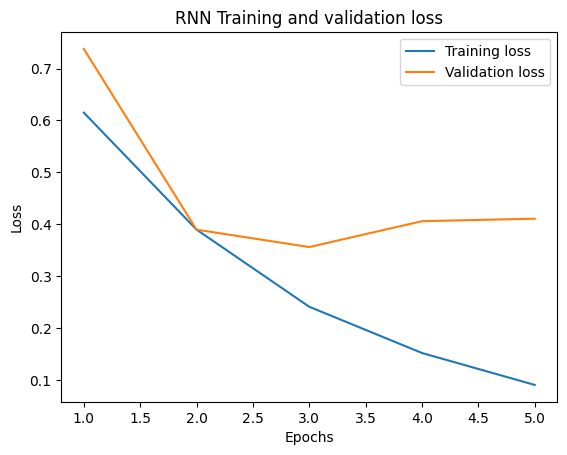

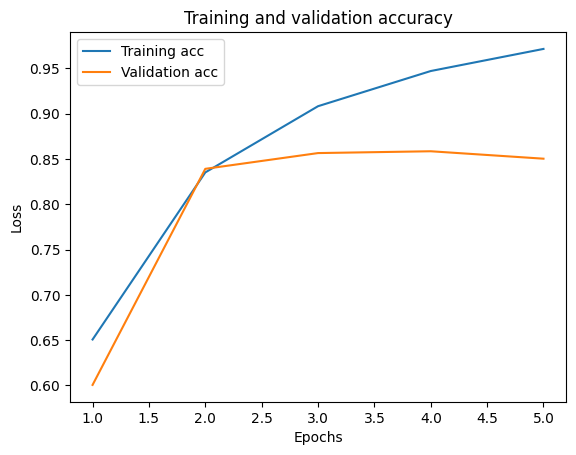

In [39]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title('RNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [40]:
results = model_rnn.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 119s 153ms/step - loss: 0.4313 - accuracy: 0.8374
[0.43134593963623047, 0.8374000191688538]


RNN model

1. Embedding = 64
1. Dropout = 0.2
1. SimpleRNN = 32
1. batch = 128
1. optimiser = Adam

Accuracy RNN = 0.837

In [45]:
#LSTM model
model_lstm = Sequential(
    [
        Embedding(max_features, 64),
        Dropout(0.2),
        LSTM(32),
        Dense(1, activation="sigmoid") 
    ]
)

In [46]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best_lstm.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [47]:
model_lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [48]:
history = model_lstm.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs = n_epochs,
    callbacks=[callback_save, callback_early_stopping],
    verbose=1,
)

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.7462
Epoch 1: val_loss improved from inf to 0.37693, saving model to best_lstm.hdf5
157/157 [==============================] - 27s 161ms/step - loss: 0.5196 - accuracy: 0.7462 - val_loss: 0.3769 - val_accuracy: 0.8474
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8913
Epoch 2: val_loss improved from 0.37693 to 0.31557, saving model to best_lstm.hdf5
157/157 [==============================] - 21s 135ms/step - loss: 0.2802 - accuracy: 0.8913 - val_loss: 0.3156 - val_accuracy: 0.8686
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9283
Epoch 3: val_loss improved from 0.31557 to 0.29914, saving model to best_lstm.hdf5
157/157 [==============================] - 16s 100ms/step - loss: 0.1986 - accuracy: 0.9283 - val_loss: 0.2991 - val_accuracy: 0.8850
Epoch 4/10
157/157 [==============================] - ETA: 0s - l

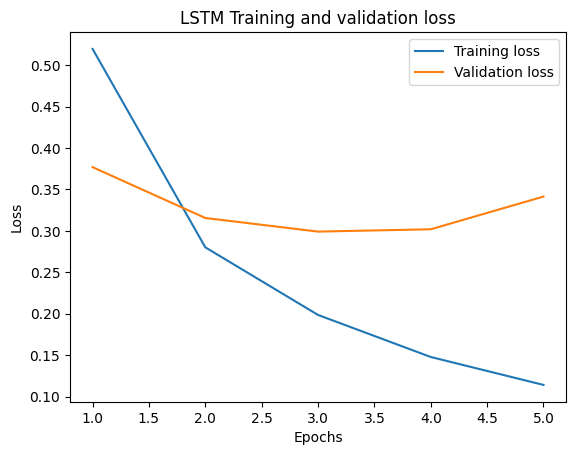

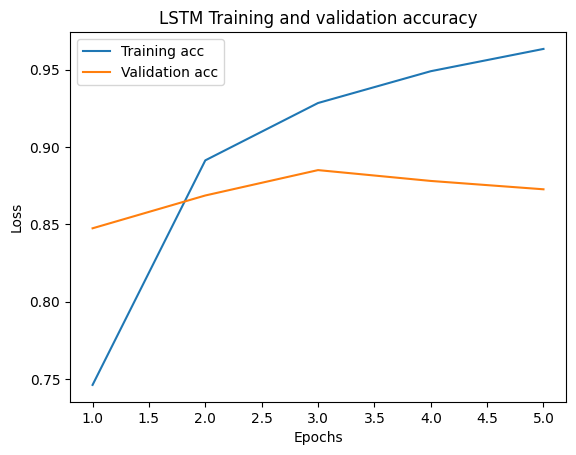

In [49]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [50]:
results = model_lstm.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 10s 13ms/step - loss: 0.3749 - accuracy: 0.8642
[0.37486007809638977, 0.8641999959945679]


LSTM

    Embedding = 64
    Dropout = 0.2
    LSTM = 32
    batch = 128
    optimiser = Adam

Accuracy LSTM = 0.864


In [70]:
#Bidirectional LSTM model
model_lstm_bd = Sequential(
    [
        Embedding(max_features, 64),
        Bidirectional(LSTM(32)),
        Dense(1, activation="sigmoid") 
    ]
)

In [64]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best_lstm_b.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [65]:
model_lstm_bd.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [66]:
history = model_lstm_bd.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs = n_epochs,
    callbacks=[callback_save, callback_early_stopping],
    verbose=1,
)

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.5091 - accuracy: 0.7487
Epoch 1: val_loss improved from inf to 0.43384, saving model to best_lstm_b.hdf5
157/157 [==============================] - 31s 177ms/step - loss: 0.5091 - accuracy: 0.7487 - val_loss: 0.4338 - val_accuracy: 0.8028
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.8929
Epoch 2: val_loss improved from 0.43384 to 0.30770, saving model to best_lstm_b.hdf5
157/157 [==============================] - 21s 134ms/step - loss: 0.2817 - accuracy: 0.8929 - val_loss: 0.3077 - val_accuracy: 0.8670
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9317
Epoch 3: val_loss did not improve from 0.30770
157/157 [==============================] - 22s 138ms/step - loss: 0.1935 - accuracy: 0.9317 - val_loss: 0.3084 - val_accuracy: 0.8732
Epoch 4/10
157/157 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9377
E

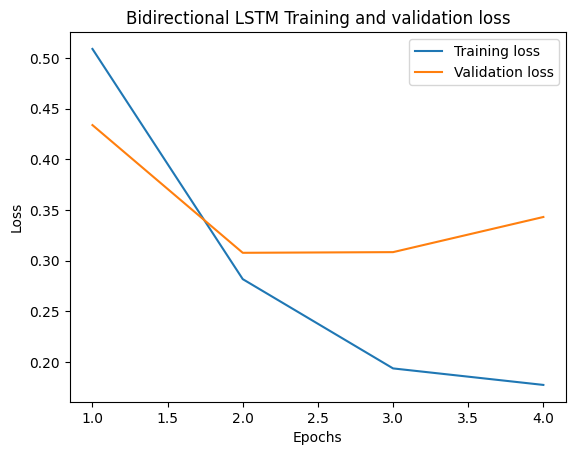

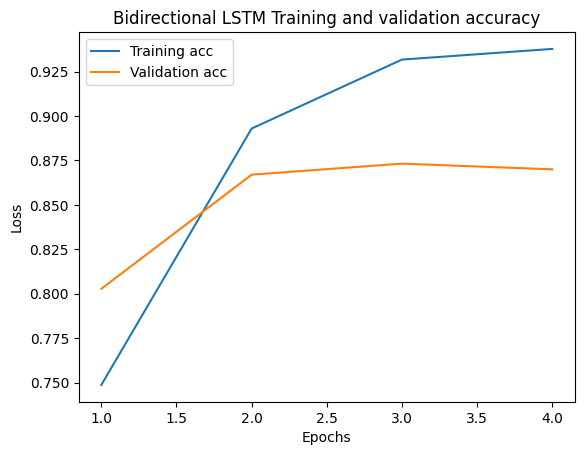

In [67]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Bidirectional LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title('Bidirectional LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [69]:
results = model_lstm_bd.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 16s 21ms/step - loss: 0.3600 - accuracy: 0.8642
[0.3599914014339447, 0.8642399907112122]


Bidirectional LSTM

    Embedding = 64
    Bidirectional LSTM = 32
    batch = 128
    optimiser = Adam

Accuracy BRNN LSTM = 0.864


In [30]:
#Deep Bidirectional LSTM model
model_lstm_d = Sequential(
    [
        Embedding(max_features, 80),
        Dropout(0.2),
        Bidirectional(LSTM(32, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(1, activation="sigmoid") 
    ]
)

In [31]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best_lstm_d.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [32]:
model_lstm_d.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [33]:
history = model_lstm_d.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs = n_epochs,
    callbacks=[callback_save, callback_early_stopping],
    verbose=1,
)

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.7756
Epoch 1: val_loss improved from inf to 0.29565, saving model to best_lstm_d.hdf5
157/157 [==============================] - 46s 264ms/step - loss: 0.4580 - accuracy: 0.7756 - val_loss: 0.2957 - val_accuracy: 0.8868
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9148
Epoch 2: val_loss improved from 0.29565 to 0.27373, saving model to best_lstm_d.hdf5
157/157 [==============================] - 33s 211ms/step - loss: 0.2300 - accuracy: 0.9148 - val_loss: 0.2737 - val_accuracy: 0.8926
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9462
Epoch 3: val_loss did not improve from 0.27373
157/157 [==============================] - 25s 161ms/step - loss: 0.1549 - accuracy: 0.9462 - val_loss: 0.2983 - val_accuracy: 0.8864
Epoch 4/10
157/157 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9643
E

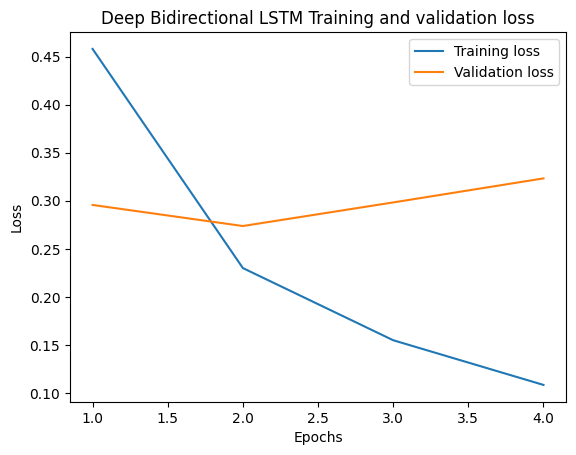

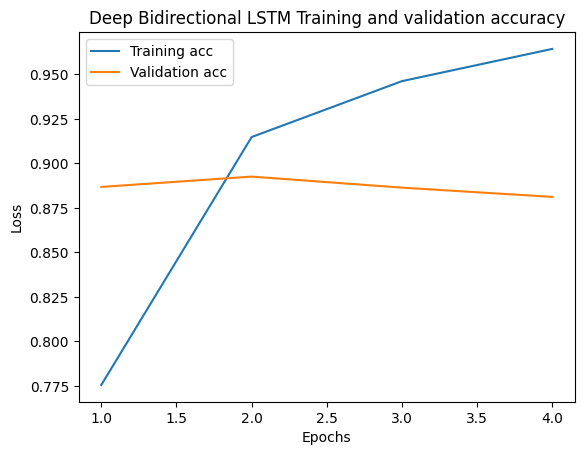

In [34]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Deep Bidirectional LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title('Deep Bidirectional LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [35]:
results = model_lstm_d.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 25s 31ms/step - loss: 0.3548 - accuracy: 0.8662
[0.3548022210597992, 0.8662400245666504]


Deep Bidirectional LSTM

    Embedding = 80
    Dropout = 0.2
    Bidirectional LSTM with return_sequences= 32
    Bidirectional LSTM = 32
    batch = 128
    optimiser = Adam

Accuracy DRNN LSTM = 0.866


In [9]:
# RandomForest
(train_data, train_labels), (test_data, test_labels) = data_set_imdb
train_data = pad_sequences(train_data, maxlen=max_len)
test_data = pad_sequences(test_data, maxlen=max_len)

In [17]:
clf_forest_10 = RandomForestClassifier(n_estimators=900, n_jobs=6, verbose=1)
clf_forest_10.fit(train_data, train_labels)
print(f"Train RandomForest: {accuracy_score(train_labels, clf_forest_10.predict(train_data))}")
print(f"Test RandomForest: {accuracy_score(test_labels, clf_forest_10.predict(test_data))}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   17.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:  4.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    5.6s


Train RandomForest: 1.0


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    5.5s


Test RandomForest: 0.54924


RandomForest:

    n_estimators = 900
    
Accuracy RandomForest = 0.549

Polyconnected CNN from keras sample

    Dense = 16, activation='relu'                                                 
    Dense = 16, activation='relu'                        
    Dense  = 1, activation='sigmoid'

Accuracy Polyconected CNN = 0.8492

In [8]:
# transformers pipe "sentiment-analysis"
(train_data, train_labels), (test_data, test_labels) = data_set_imdb

In [9]:
# prepare test_data
text_to_transform = []
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
for idx in range(len(train_data)):
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '') for i in test_data[idx]])
    text_to_transform.append(decoded_review)
text_to_transform[0]

" please give this one a miss br br   and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite  so all you madison fans give this a miss"

In [10]:
pipe = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
2023-08-26 05:59:58.133251: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2023-08-26 05:59:58.242675: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2023-08-26 05:59:58.387877: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForS

In [17]:
st_time = time.time()
arr = []
decode_to_binary = {"NEGATIVE": 0, "POSITIVE": 1}
len_test = 5000
for i, text_ in enumerate(text_to_transform[:len_test]):
    if (i%100) == 0:
        print("Left: ", len_test - i, round(time.time() - st_time), "sec")
    res = decode_to_binary[pipe(text_[:1500])[0]["label"]] 
    arr.append(res == test_labels[i])
end_time = time.time()
print("Time", end_time - st_time, "s")

Left:  5000 0 sec
Left:  4900 41 sec
Left:  4800 81 sec
Left:  4700 123 sec
Left:  4600 164 sec
Left:  4500 204 sec
Left:  4400 246 sec
Left:  4300 287 sec
Left:  4200 328 sec
Left:  4100 369 sec
Left:  4000 411 sec
Left:  3900 453 sec
Left:  3800 493 sec
Left:  3700 534 sec
Left:  3600 576 sec
Left:  3500 617 sec
Left:  3400 659 sec
Left:  3300 702 sec
Left:  3200 742 sec
Left:  3100 782 sec
Left:  3000 822 sec
Left:  2900 864 sec
Left:  2800 905 sec
Left:  2700 945 sec
Left:  2600 986 sec
Left:  2500 1026 sec
Left:  2400 1065 sec
Left:  2300 1107 sec
Left:  2200 1148 sec
Left:  2100 1190 sec
Left:  2000 1230 sec
Left:  1900 1271 sec
Left:  1800 1312 sec
Left:  1700 1353 sec
Left:  1600 1395 sec
Left:  1500 1435 sec
Left:  1400 1477 sec
Left:  1300 1517 sec
Left:  1200 1558 sec
Left:  1100 1599 sec
Left:  1000 1639 sec
Left:  900 1683 sec
Left:  800 1725 sec
Left:  700 1770 sec
Left:  600 1812 sec
Left:  500 1854 sec
Left:  400 1893 sec
Left:  300 1935 sec
Left:  200 1977 sec
Left:  1

In [19]:
print(f"Accuracy Transformer Pipe 'sentiment-analysis' = {np.mean(arr)}")

Accuracy Transformer Pipe 'sentiment-analysis' = 0.872


# Conclusion
    Accuracy RandomForest = 0.549
    Accuracy Polyconected CNN = 0.8492
    Accuracy RNN = 0.837
    Accuracy LSTM = 0.864
    Accuracy BRNN LSTM = 0.864
    Accuracy DRNN LSTM = 0.866
    Accuracy Transformer Pipe 'sentiment-analysis' = 0.872
RandomForest and SVC can not achive good result. Simple RNN gives good result but have too long time education and easy overfit. LSTM have better result, espessialy DRNN LSTM, but needs dropout because easy overfit. The best score gain ransformer pipe 'sentiment-analysis'. This model is really difficult and our own LSTM models have equal results